# Батчнорм и дропаут

## CIFAR10 (без батчнорма и дропаута)

In [7]:
import torch
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

sns.set(font_scale=1.4, style="darkgrid")

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Загрузка датасета и получение DataLoader'ов

In [9]:
def get_loaders(batch_size):
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  root = "./data"

  train_set = datasets.CIFAR10(root=root, train=True, 
                               transform=transform, download=True)
  test_set = datasets.CIFAR10(root=root, train=False, 
                              transform=transform, download=True)
  
  train_loader = DataLoader(train_set, batch_size=batch_size,
                            shuffle=True, num_workers=2)
  test_loader = DataLoader(test_set, batch_size=batch_size, 
                           shuffle=False, num_workers=2)
  
  return train_loader, test_loader

### Обучение и получение информации для визуализации

In [24]:
def fit(epochs, model, criterion, optimizer, 
        train_loader, test_loader, lr_scheduler=None):
  train_accuracies, test_accuracies = [], []
  train_losses, test_losses = [], []

  for epoch in trange(epochs):
    print(f"Epoch {epoch + 1}")

    train_loss_sum = 0
    epoch_correct = 0
    epoch_all = 0
    model.train()
    
    for x_batch, y_batch in tqdm(train_loader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      output = model(x_batch)
      epoch_correct += (output.argmax(-1) == y_batch).sum().item()
      epoch_all += y_batch.shape[0]

      loss = criterion(output, y_batch)
      train_loss_sum += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_losses.append(train_loss_sum / len(train_loader))
    train_accuracies.append(epoch_correct / epoch_all)

    test_loss_sum = 0
    epoch_correct = 0
    epoch_all = 0
    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        output = model(x_batch)
        loss = criterion(output, y_batch)
        test_loss_sum += loss.item()
        epoch_correct += (output.argmax(-1) == y_batch).sum().item()
        epoch_all += y_batch.shape[0]
    
    test_losses.append(test_loss_sum / len(test_loader))
    test_accuracies.append(epoch_correct / epoch_all)

    if lr_scheduler:
      lr_scheduler.step()

    print(f"Train loss: {train_losses[-1]}, \tTest accuracy: {test_accuracies[-1]}")
  return train_losses, train_accuracies, test_losses, test_accuracies

### Отображение результатов

In [11]:
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
  plt.figure(figsize=(16, 10))
  plt.subplot(2, 1, 1)
  plt.plot(train_losses, label="Train loss", color="red")
  plt.plot(test_losses, label="Test loss", color="blue")
  #plt.title("Loss by epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(train_accuracies, label="Train accuracy", color="red")
  plt.plot(test_accuracies, label="Test accuracy", color="blue")
  #plt.title("Accuracy by epoch")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

### Модель

In [12]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(in_features=6 * 6 * 16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 6 * 6 * 16)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Итоги

In [13]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 10
batch_size = 4

results = fit(epochs, model, criterion, optimizer, *get_loaders(batch_size))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.74373840310812, 	Test accuracy: 0.4846
Epoch 2


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.3193717057049275, 	Test accuracy: 0.5733
Epoch 3


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.1594448611311614, 	Test accuracy: 0.6064
Epoch 4


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.053186160192117, 	Test accuracy: 0.6156
Epoch 5


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.9711542780413851, 	Test accuracy: 0.6275
Epoch 6


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.9030742424369045, 	Test accuracy: 0.64
Epoch 7


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.8496493120804801, 	Test accuracy: 0.6397
Epoch 8


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.8013953128899448, 	Test accuracy: 0.6484
Epoch 9


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.7537712549748272, 	Test accuracy: 0.6296
Epoch 10


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 0.7124886285202741, 	Test accuracy: 0.6364


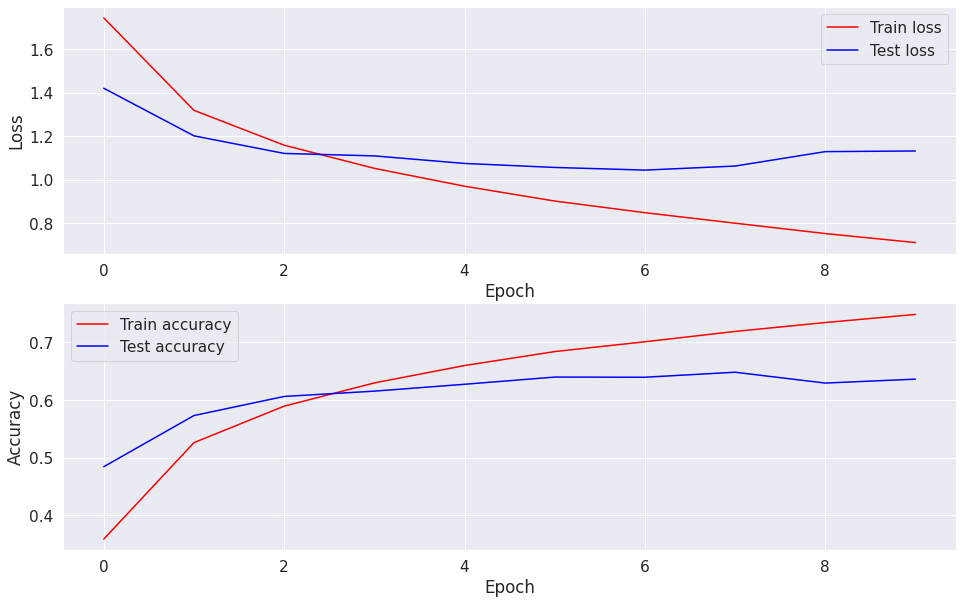

In [14]:
plot_results(*results)

## CIFAR10 (батчнорм)

### Пример работы BatchNorm в обычном случае и с Conv-слоями

In [15]:
import numpy as np
batch = np.array([
                  [
                    [[1, 1, 1],
                     [2, 2, 2],
                     [3, 3, 3]],
                    [[4, 4, 4],
                     [5, 5, 5],
                     [6, 6, 6]],
                    [[7, 7, 7],
                     [8, 8, 8],
                     [9, 9, 9]]
                  ],
                  [
                    [[2, 2, 2],
                     [4, 4, 4],
                     [6, 6, 6]],
                    [[8, 8, 8],
                     [10, 10, 10],
                     [12, 12, 12]],
                    [[14, 14, 14],
                     [16, 16, 16],
                     [18, 18, 18]]
                  ]
])

batch.shape

(2, 3, 3, 3)

In [16]:
batch.mean(axis=(0,2,3))

array([ 3. ,  7.5, 12. ])

In [17]:
batch.mean(axis=(0,))

array([[[ 1.5,  1.5,  1.5],
        [ 3. ,  3. ,  3. ],
        [ 4.5,  4.5,  4.5]],

       [[ 6. ,  6. ,  6. ],
        [ 7.5,  7.5,  7.5],
        [ 9. ,  9. ,  9. ]],

       [[10.5, 10.5, 10.5],
        [12. , 12. , 12. ],
        [13.5, 13.5, 13.5]]])

### Модель

In [18]:
from torch.nn.modules.pooling import MaxPool2d
class ModelBatchNorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(6)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(6 * 6 * 16, 120)
    self.bn3 = nn.BatchNorm1d(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(-1, 6 * 6 * 16)
    x = F.relu(self.bn3(self.fc1(x)))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [19]:
model_bn1 = ModelBatchNorm().to(device)
optimizer = optim.SGD(model_bn1.parameters(), lr=0.004, momentum=0.9)
criterion = nn.CrossEntropyLoss()

results_bn1 = fit(10, model_bn1, criterion, optimizer, *get_loaders(4))

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.720632879960537, 	Test accuracy: 0.5386
Epoch 2


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.5245549045038223, 	Test accuracy: 0.5666
Epoch 3


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.4509325854218007, 	Test accuracy: 0.5904
Epoch 4


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.4013069043564796, 	Test accuracy: 0.58
Epoch 5


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.3617702363038062, 	Test accuracy: 0.6086
Epoch 6


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.3313380018258094, 	Test accuracy: 0.6199
Epoch 7


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.311606031896025, 	Test accuracy: 0.6221
Epoch 8


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2935795883953571, 	Test accuracy: 0.6203
Epoch 9


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2732475036346913, 	Test accuracy: 0.6237
Epoch 10


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2529924237067998, 	Test accuracy: 0.6249


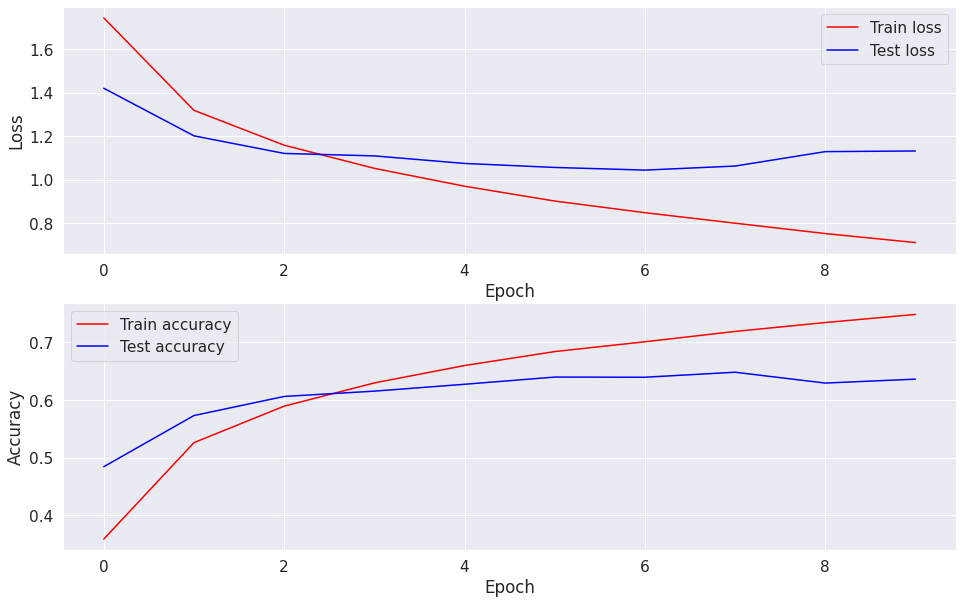

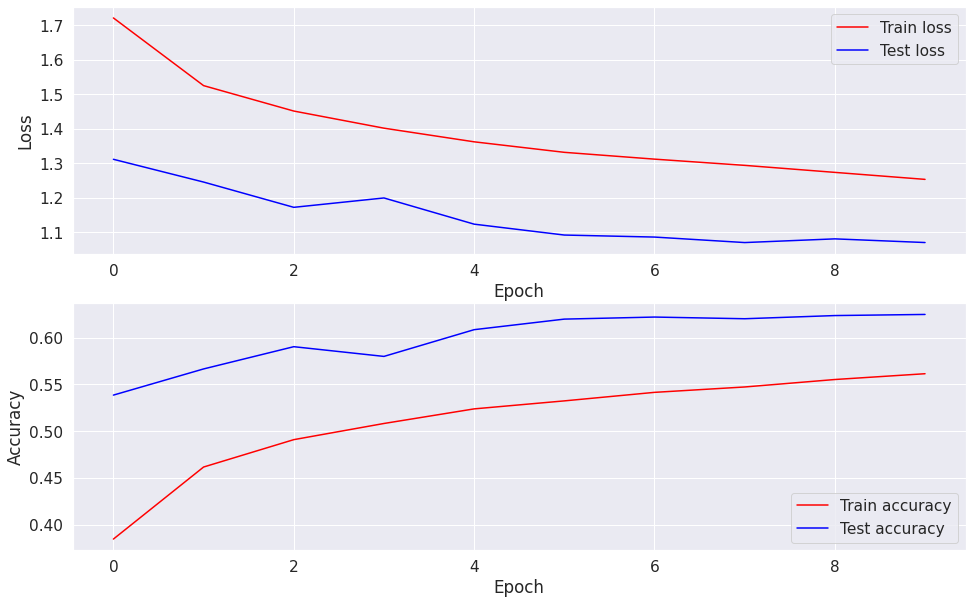

In [20]:
plot_results(*results)
plot_results(*results_bn1)

## CIFAR10 (dropout)

### Модель

In [21]:
class ModelDropout(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
    self.fc1 = nn.Linear(6 * 6 * 16, 120)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 6 * 6 * 16)
    x = self.dropout(F.relu(self.fc1(x)))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [22]:
model_dropout = ModelDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=0.001, momentum=0.9)

results_dropout = fit(10, model_dropout, criterion, optimizer, *get_loaders(4))

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.7849729977154731, 	Test accuracy: 0.4807
Epoch 2


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.461832205439806, 	Test accuracy: 0.537
Epoch 3


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.346744434196949, 	Test accuracy: 0.5717
Epoch 4


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2776671941930056, 	Test accuracy: 0.5914
Epoch 5


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.231386114912927, 	Test accuracy: 0.603
Epoch 6


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.1928911811468006, 	Test accuracy: 0.6087
Epoch 7


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.1634259947511554, 	Test accuracy: 0.6023
Epoch 8


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.1426540862694383, 	Test accuracy: 0.6236
Epoch 9


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.1241017585680633, 	Test accuracy: 0.6213
Epoch 10


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.102184730835259, 	Test accuracy: 0.6304


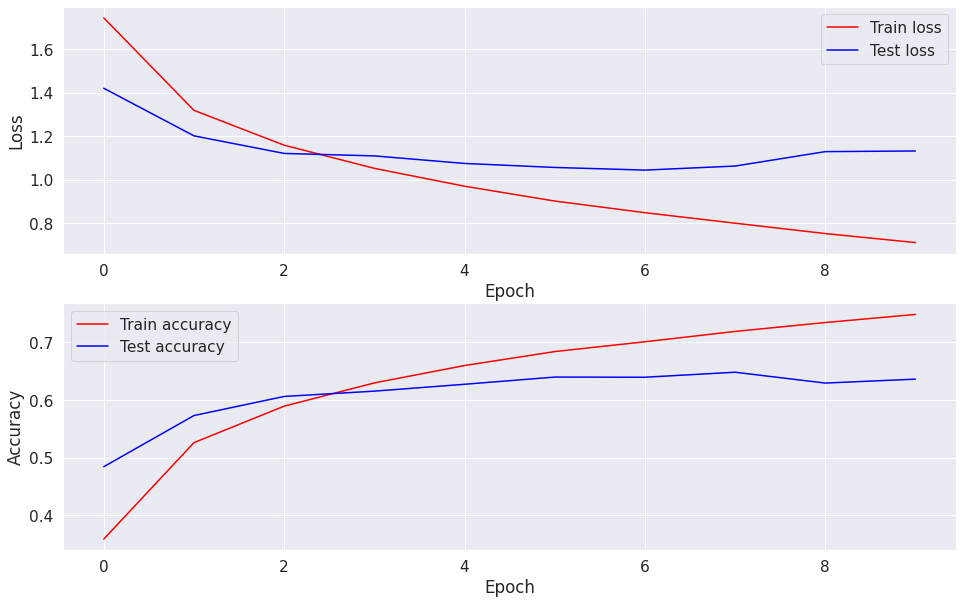

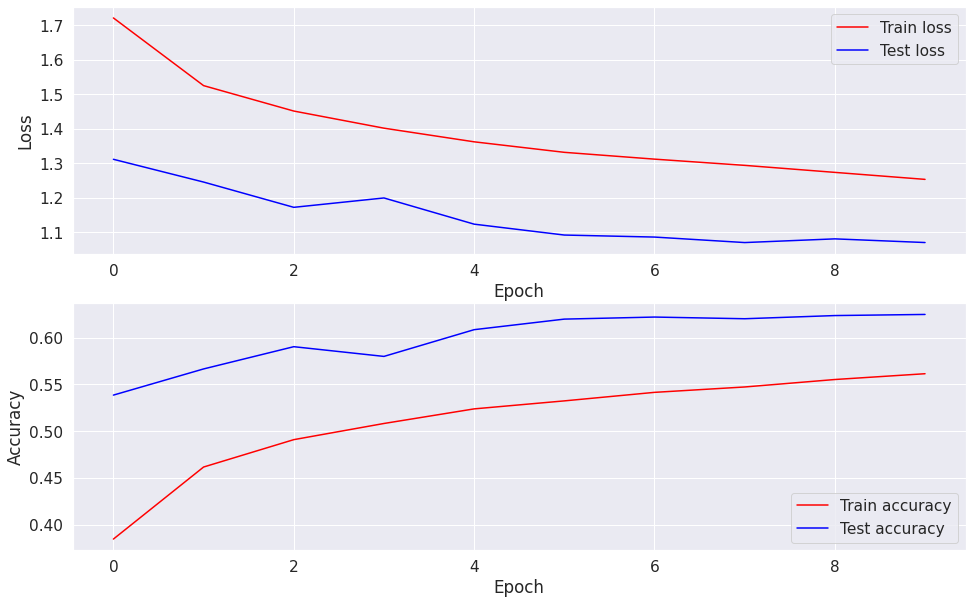

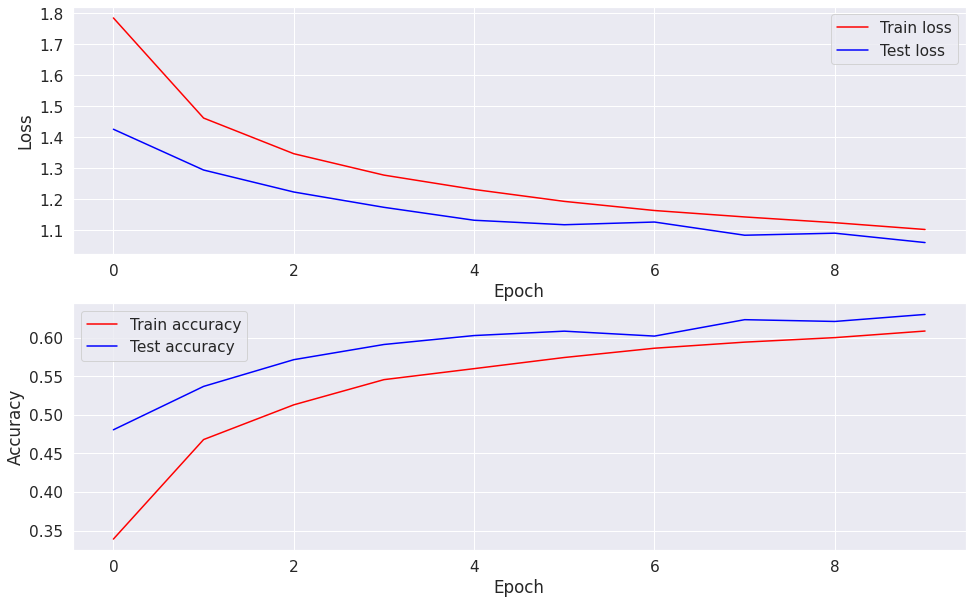

In [23]:
plot_results(*results)
plot_results(*results_bn1)
plot_results(*results_dropout)

# Schedulers

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.6750590648412704, 	Test accuracy: 0.4403
Epoch 2


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.4291020135116577, 	Test accuracy: 0.4985
Epoch 3


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.3435053555750847, 	Test accuracy: 0.5067
Epoch 4


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2988139992034435, 	Test accuracy: 0.5315
Epoch 5


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2767320566362144, 	Test accuracy: 0.5345
Epoch 6


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2628902711200714, 	Test accuracy: 0.5426
Epoch 7


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2551828524768351, 	Test accuracy: 0.5416
Epoch 8


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.251815265815258, 	Test accuracy: 0.5424
Epoch 9


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2497516711860894, 	Test accuracy: 0.5436
Epoch 10


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Train loss: 1.2489270539581776, 	Test accuracy: 0.5452


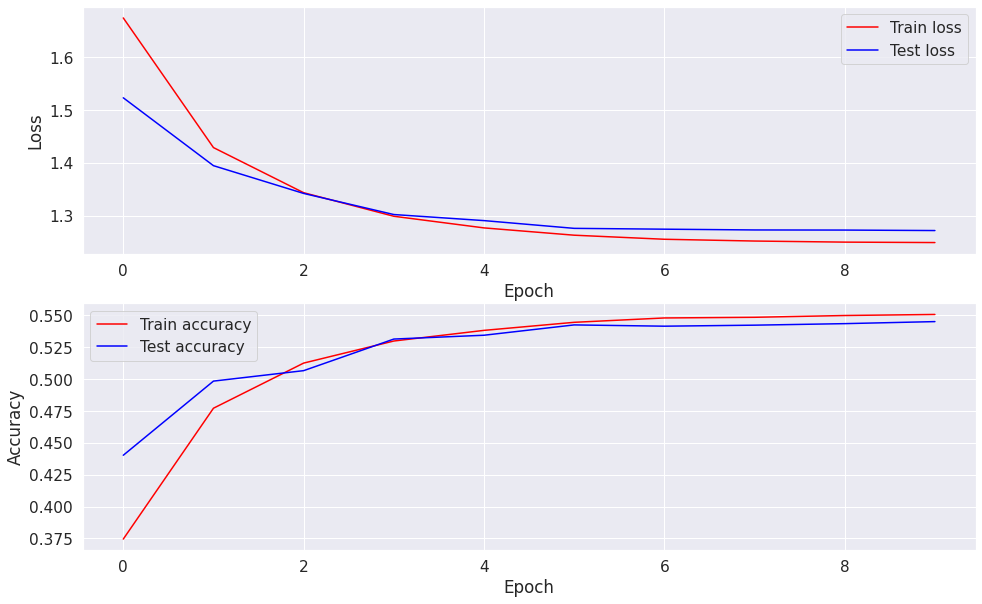

In [26]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

epochs = 10
batch_size = 4

results = fit(epochs, model, criterion, optimizer, *get_loaders(batch_size), lr_scheduler)
plot_results(*results)

# Чекпоинтинг

## Сохранение весов модели

In [29]:
weights = model.state_dict()
torch.save(weights, "simple_model_weights.pth")

In [30]:
new_model = Model()
new_model.load_state_dict(torch.load("simple_model_weights.pth"))
new_model.eval()

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_set = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)


Files already downloaded and verified


In [33]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def predict(model, dataset, index):
  image, label = dataset[index]
  prediction = model(image[None, :, :, :]).argmax(-1)
  plt.imshow(image.permute(1, 2, 0).numpy())
  plt.title(f"Prediction: {classes[prediction]}, True: {classes[label]}")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


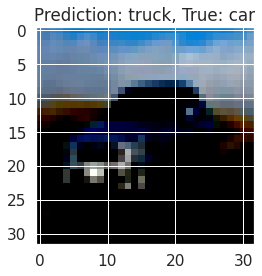

In [38]:
predict(new_model, test_set, np.random.randint(low=0, high=10000))

## Глобальный чекпоинт

In [40]:
EPOCH = 10
PATH = "model.pt"
LOSS = results[0][-1]

torch.save({
    "epoch" : EPOCH,
    "model_state_dict" : model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
    "loss" : LOSS
}, PATH)

In [42]:
model = Model()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
epoch = checkpoint["epoch"]
loss = checkpoint["loss"]

model.eval()


Model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


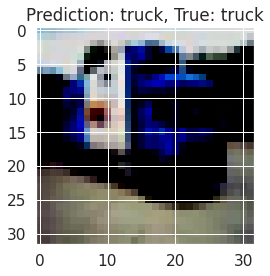

In [43]:
predict(new_model, test_set, np.random.randint(low=0, high=10000))